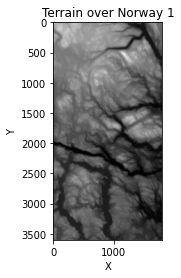

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
# Load the terrain
terrain = imread('data/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [2]:
def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k[:, 1:])

	return X

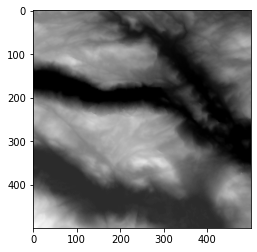

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_erro, r2_scorer
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

z = te2000n2500[150051000,
z -= np.min(z)
z = z / np.max(z)

plt.imshow(z, cmap='gray')
t data

x = np.li nspace(0,1, np.shape(z)[0])
y = np.l inspace(0,1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# __OLS__

In [52]:
from sklearn.linear_model import LinearRegression

RANDOM_STAT= 51042
max_degree10
degrees = np.arange(1, max_degree)= ols_6

_rain_MSE = np.zeros(max_d - 1egols_ree)
test_MSE = np.zeros(max_ - 1d
ols_r2 = np.zeros(max_degree - 1)eols_gree)
cv_score = np.zeros(max - 1_degree)

for idegrees)_degree)):
    X = create_X(x, y, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, tes
    model = m
    model = make_pipeline(StanLinearRegression()arRegression())
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = mode
.predols_train_MSEt) - 1

    train_MSE[i] = z_trainuaz_tildeor(z_tols_test_MSEtr - 1ain)
    test_MSE[i] =z_testsqz_prede
    ols_r2[i - 1] = r2_score(z_test, z_pred)ed_error', cv=KFold(10)))

100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


In [53]:
for i in tqdm(degrees):
    X = create_X(x, y, i)
    model = make_pipeline(StandardScaler(), LinearRegression())
    ols_cv_score[i - 1] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10)))

100%|██████████| 9/9 [00:42<00:00,  4.72s/it]


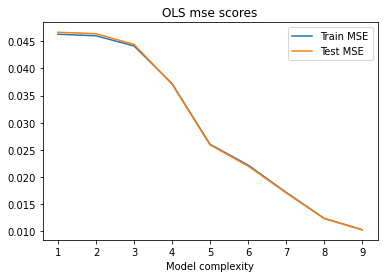

In [54]:
fig, ax = plt.subplots())
ax.plodegreese)ols_, train_MSE, label='Tra MSEin')
ax.pldegreeseeols_), test_MSE, label='T MSEeste')
ax.leg
ax.set_title('OLS mse scores')end()
ax.set_xlabel('Model comple('MSE')
plt.show()

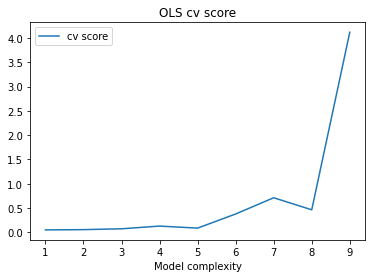

In [55]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_cv_score, label='cv score')
ax.legend()
ax.set_title('OLS cv score')
ax.set_xlabel('Model complexity')
plt.show()

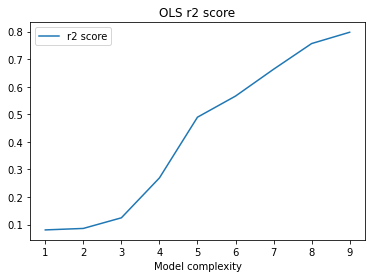

In [56]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('Model complexity')
plt.show()

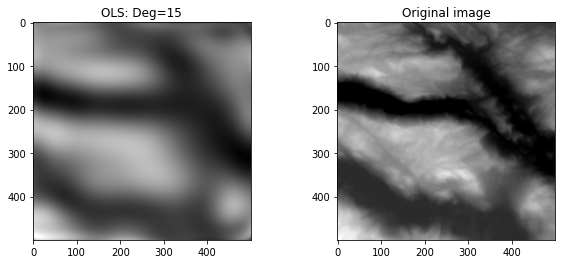

In [130]:
X = create_X(x, y, 15)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('OLS: Deg=15')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# __Ridge__

In [78]:
from sklearn.linear_model import Ridge

num_lambdas 20
degree = 9= 4

lambdas = np.logsp6ce6-4, 4, num_lam

ridge_train_MSE = np.zeros(num_lambdas)
ridge_test_MSE = np.zeros(num_lambdas)
ridge_r2 = np.zeros(num_lambdas)bridge_das)
cv_score = np.zeros(num_lai
itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    ridge_train_MSE[itr] = mean_squared_error(z_test, z_pred)
    ridge_test_MSE[itr] = mean_squared_error(z_test, z_pred)
    ridge_r2[itr] = r2_score(z_test, z_pred)
    itr += 1core_itr += 1

100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


In [65]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    ridge_cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10)))
    cv_score_itr += 1

100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


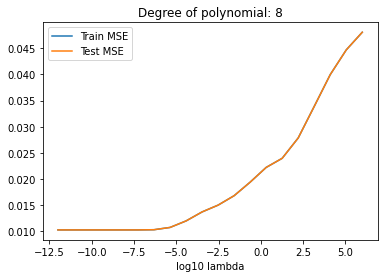

In [75]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), ridge_test_MSE, label='Test MSE')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()how()

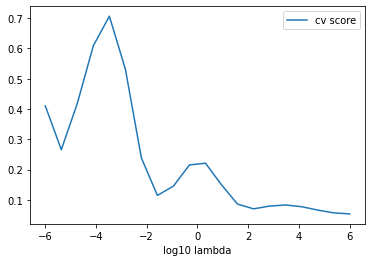

In [66]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_cv_score, label='cv score')
ax.legend()
ax.set_xlabel('log10 lambda')
plt.show()

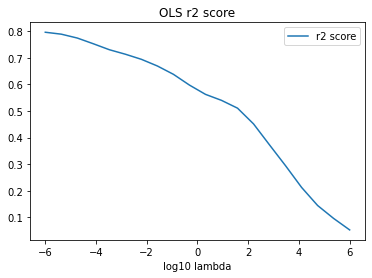

In [68]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('log10 lambda')
plt.show()

Below we perform a gridsearch to find the optimal polynomial degree and lambda value

In [70]:
max_degree = 15
degrees = np.arange(1, max_degree)

ridge_r2_grid = np.zeros((max_degree, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

        model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        ridge_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


([<matplotlib.axis.XTick at 0x7fc700374ef0>,
 [Text(0, 0, '-6'), Text(5, 0, '-3'), Text(10, 0, '0'), Text(15, 0, '3')])

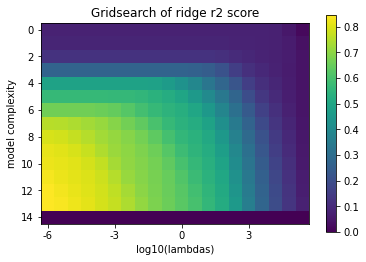

In [101]:
idx = np.where(ridge_r2_grid == np.amax(ridge_r2_grid))

fig, ax = plt.subplots()
cb = ax.imshow(ridge_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of ridge r2 score')
plt.colorbar(cb)
plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))

The optimal lambda parameter seems to always be close to zero.

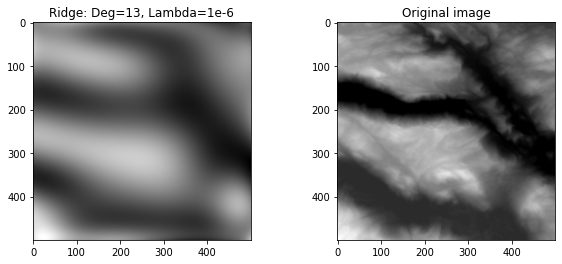

In [136]:
X = create_X(x, y, 13)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Ridge(1e-6, fit_intercept=True))
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('Ridge: Deg=13, Lambda=1e-6')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# Lasso

In [116]:
from sklearn.linear_model import Lasso

num_lambdas = 20
degree = 5

lambdas = np.logspace(-6, 6, num_lambdas)

train_MSE = np.zeros(num_lambdas)
test_MSE = np.zeros(num_lambdas)
cv_score = np.zeros(num_lambdas)

mse_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=False))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    train_MSE[mse_itr] = mean_squared_error(z_tilde, z_train)
    test_MSE[mse_itr] = mean_squared_error(z_pred, z_test)
    mse_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14752.890018403697, tolerance: 3.217443439321755
  positive)
  5%|▌         | 1/20 [00:04<01:21,  4.31s/it]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14556.045931519837, tolerance: 3.217443439321755
  positive)
 10%|█         | 2/20 [00:08<01:16,  4.25s/it]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13704.579518287106, tolerance: 3.217443439321755
  positive)
 15%|█▌        | 3/20 [00:12<01:10,  4.15s/it]/home/hakon

In [117]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=False))
    cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10)))
    cv_score_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18805.78975156381, tolerance: 4.219059269050902
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18497.91670815441, tolerance: 4.0366654791983025
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18641.901774697322, tolerance: 4.078157031121409
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You mi

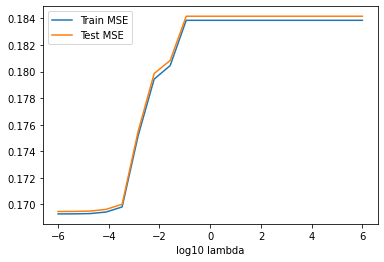

In [118]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), test_MSE, label='Test MSE')
ax.legend()
ax.set_xlabel('log10 lambda')
plt.show()

0.18237352732133155


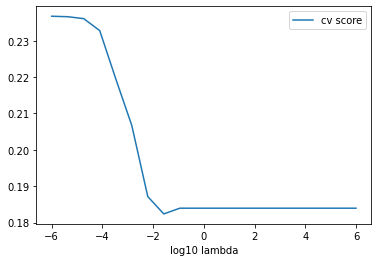

In [120]:
fig, ax = plt.subplots()
print(np.min(cv_score))
ax.plot(np.log10(lambdas), cv_score, label='cv score')
ax.legend()
ax.set_xlabel('log10 lambda')
plt.show()

In [22]:
X = create_X(x, y, 3)[:, 1:]
print(X)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Lasso(alpha=0.182374, fit_intercept=False))
model.fit(X_train, z_train)

z_pred = model.predict(X_test)
mse = mean_squared_error(z_pred, z_test)
r2 = r2_score(z_pred, z_test)

print(z_pred)

print(mse, r2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00400802e-03 0.00000000e+00 4.01604813e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.00801603e-03 0.00000000e+00 1.60641925e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.95991984e-01 1.00000000e+00 9.92000032e-01 ... 9.92000032e-01
  9.95991984e-01 1.00000000e+00]
 [9.97995992e-01 1.00000000e+00 9.95996000e-01 ... 9.95996000e-01
  9.97995992e-01 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


NameError: name 'Lasso' is not defined

In [9]:
from sklearn.linear_model import Lasso

max_degree = 13
degrees = np.arange(1, max_degree)

num_lambdas = 10
lambdas = np.logspace(-4, -4, num_lambdas)

lasso_r2_grid = np.zeros((max_degree, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=42, test_size=0.3)

        model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        lasso_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

tive)
 80%|████████  | 8/10 [00:47<00:11,  5.92s/it]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930.3859331752328, tolerance: 0.8836771496602193
  positive)
 90%|█████████ | 9/10 [00:53<00:05,  5.89s/it]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930.3859331752328, tolerance: 0.8836771496602193
  positive)
  0%|          | 0/10 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1736.1288554073979, tolerance: 0.8836771496602193
  positive)
 10%|█         | 1/10 [00:07<01:09,  7.71s/it]/h

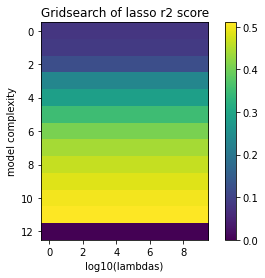

In [11]:
idx = np.where(lasso_r2_grid == np.amax(lasso_r2_grid))

fig, ax = plt.subplots()
cb = ax.imshow(lasso_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of lasso r2 score')
plt.colorbar(cb)
# plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))